# 市值的時間序練動畫

我們要用 Plotly 來畫出市值的時間序練動畫，它適合做出互動式或者有動畫的圖表

In [1]:
#! pip install yfinance tqdm plotly pandas streamlit
import warnings

import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
from tqdm.auto import tqdm
import yfinance as yf

warnings.filterwarnings("ignore", category=FutureWarning)

## 選擇股票代號（ticker）

In [2]:
# Google, Tencent, Tesla, Microsoft, Meta, AMD, Alibaba, Amazon, Apple, Baidu
tickers = [
    "GOOGL",
    "TCEHY",
    "TSLA",
    "MSFT",
    "META",
    "AMD",
    "BABA",
    "AMZN",
    "AAPL",
    "BIDU",
]

`yfinance` 是一個可以從 Yahoo Finance 下載股票資料的套件

In [3]:
t = yf.Tickers(" ".join(tickers))
msft = t.tickers["MSFT"]

如果要算一個公司的市值，我們可以用一天的收盤價（`Close`）乘以總股數（`Shares`）

`history()` 可以下載歷史的股價資料

In [4]:
msft.history(period="max")

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13 00:00:00-05:00,0.054893,0.062965,0.054893,0.060274,1031788800,0.0,0.0
1986-03-14 00:00:00-05:00,0.060274,0.063504,0.060274,0.062427,308160000,0.0,0.0
1986-03-17 00:00:00-05:00,0.062427,0.064042,0.062427,0.063504,133171200,0.0,0.0
1986-03-18 00:00:00-05:00,0.063503,0.064042,0.061350,0.061888,67766400,0.0,0.0
1986-03-19 00:00:00-05:00,0.061888,0.062427,0.060274,0.060812,47894400,0.0,0.0
...,...,...,...,...,...,...,...
2023-12-07 00:00:00-05:00,368.230011,371.450012,366.320007,370.950012,23118900,0.0,0.0
2023-12-08 00:00:00-05:00,369.200012,374.459991,368.230011,374.230011,20144800,0.0,0.0
2023-12-11 00:00:00-05:00,368.480011,371.600006,366.100006,371.299988,27708800,0.0,0.0


`get_shares_full()` 可以下載歷史股票的總股數

歷史的資料沒有到很遠

In [5]:
msft.get_shares_full(start="2000-01-01")

2015-10-23 00:00:00-04:00    7987910000
2016-01-28 00:00:00-05:00    7909300000
2016-04-21 00:00:00-04:00    7860470000
2016-07-20 00:00:00-04:00    7808000000
2016-07-28 00:00:00-04:00    7792520000
                                ...    
2023-12-01 00:00:00-05:00    7432260096
2023-12-02 00:00:00-05:00    7432260096
2023-12-06 00:00:00-05:00    7432260096
2023-12-08 00:00:00-05:00    7432260096
2023-12-13 00:00:00-05:00    7432260096
Length: 349, dtype: int64

我們可以定義一個函數 `get_market_cap()` 來計算市值

In [5]:
def get_market_cap(ticker: yf.Ticker) -> pd.DataFrame:
    """
    Calculate the market capitalization for a given stock ticker.

    Parameters:
    ticker (yf.Ticker): The stock ticker object.

    Returns:
    pd.DataFrame: DataFrame containing the historical market capitalization data.
    """
    keep_cols = ["Close"]
    hist = ticker.history(period="max")[keep_cols]
    shares = ticker.get_shares_full(start="2000-01-01")
    shares = shares[~shares.index.duplicated(keep="first")]  # shares 可能一天有多個值，只取第一個
    shares.name = "Shares"

    hist = hist.merge(
        shares, left_index=True, right_index=True
    )  # merge by index (date)
    hist.index.name = "Date"
    hist["MarketCap"] = hist["Close"] * hist["Shares"]
    hist = hist.reset_index()  # 將 index (Date) 轉成 column
    return hist

In [6]:
dfs = []
for ticker in tqdm(tickers):
    hist = get_market_cap(t.tickers[ticker])
    hist["Ticker"] = ticker
    dfs.append(hist)
dfs[0].head()

  0%|          | 0/10 [00:00<?, ?it/s]

,Date,Close,Shares,MarketCap,Ticker
0,2015-10-29 00:00:00-04:00,37.242500,687725000,2.561260e+10,GOOGL
1,2016-02-01 00:00:00-05:00,38.538502,687348000,2.648936e+10,GOOGL
2,2016-02-11 00:00:00-05:00,35.318001,688320000,2.431009e+10,GOOGL
3,2016-02-12 00:00:00-05:00,35.344501,688330000,2.432868e+10,GOOGL
4,2016-02-26 00:00:00-05:00,36.243000,688320000,2.494678e+10,GOOGL


## 合併所有DF

In [7]:
df_concat = pd.concat(dfs, axis="index", ignore_index=True)
df_concat

,Date,Close,Shares,MarketCap,Ticker
0,2015-10-29 00:00:00-04:00,37.242500,687725000,2.561260e+10,GOOGL
1,2016-02-01 00:00:00-05:00,38.538502,687348000,2.648936e+10,GOOGL
2,2016-02-11 00:00:00-05:00,35.318001,688320000,2.431009e+10,GOOGL
3,2016-02-12 00:00:00-05:00,35.344501,688330000,2.432868e+10,GOOGL
4,2016-02-26 00:00:00-05:00,36.243000,688320000,2.494678e+10,GOOGL
...,...,...,...,...,...
4056,2023-12-06 00:00:00-05:00,113.379997,352214016,3.993402e+10,BIDU
4057,2023-12-07 00:00:00-05:00,115.779999,355302016,4.113687e+10,BIDU
4058,2023-12-08 00:00:00-05:00,113.449997,349596992,3.966178e+10,BIDU
4059,2023-12-12 00:00:00-05:00,113.150002,349596992,3.955690e+10,BIDU


看看幾個公司的市值

看圖可以知道 `AMZN` 和 `AAPL` 的資料不完整

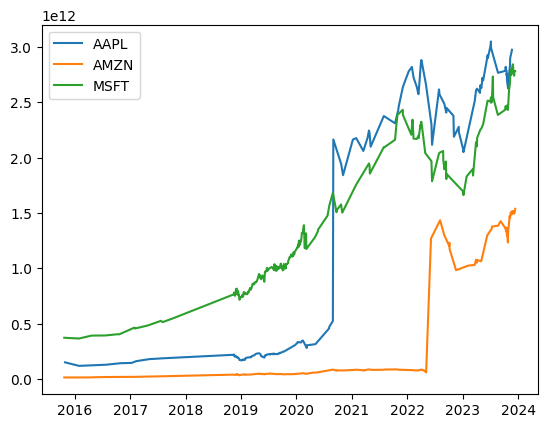

In [8]:
aapl_mc = df_concat.query('Ticker == "AAPL"')
amzn_mc = df_concat.query('Ticker == "AMZN"')
msft_mc = df_concat.query('Ticker == "MSFT"')

plt.plot(aapl_mc["Date"], aapl_mc["MarketCap"], label="AAPL")
plt.plot(amzn_mc["Date"], amzn_mc["MarketCap"], label="AMZN")
plt.plot(msft_mc["Date"], msft_mc["MarketCap"], label="MSFT")
plt.legend()

## 視覺化前處理

為了做視覺化，每個日期需要每個公司的資料（就算根本沒資料），因此我們用 `Date` 和 `Ticker` 建立一個笛卡兒積（cartesian product）的多層索引

<img src="https://www.cs.mtsu.edu/~xyang/3080/images/cartesian.png" width="300">

In [9]:
key_cols = ["Date", "Ticker"]
multi_index = pd.MultiIndex.from_product(
    [df_concat[col].unique() for col in key_cols], names=key_cols
)
multi_index

MultiIndex([('2015-10-29 00:00:00-04:00', 'GOOGL'),
            ('2015-10-29 00:00:00-04:00', 'TCEHY'),
            ('2015-10-29 00:00:00-04:00',  'TSLA'),
            ('2015-10-29 00:00:00-04:00',  'MSFT'),
            ('2015-10-29 00:00:00-04:00',  'META'),
            ('2015-10-29 00:00:00-04:00',   'AMD'),
            ('2015-10-29 00:00:00-04:00',  'BABA'),
            ('2015-10-29 00:00:00-04:00',  'AMZN'),
            ('2015-10-29 00:00:00-04:00',  'AAPL'),
            ('2015-10-29 00:00:00-04:00',  'BIDU'),
            ...
            ('2023-01-25 00:00:00-05:00', 'GOOGL'),
            ('2023-01-25 00:00:00-05:00', 'TCEHY'),
            ('2023-01-25 00:00:00-05:00',  'TSLA'),
            ('2023-01-25 00:00:00-05:00',  'MSFT'),
            ('2023-01-25 00:00:00-05:00',  'META'),
            ('2023-01-25 00:00:00-05:00',   'AMD'),
            ('2023-01-25 00:00:00-05:00',  'BABA'),
            ('2023-01-25 00:00:00-05:00',  'AMZN'),
            ('2023-01-25 00:00:00-05:00',  'AAPL

我們再把目前的資料搬到使用 `MultiIndex` 的新 DataFrame

In [10]:
df = pd.DataFrame(index=multi_index).merge(df_concat, on=key_cols, how="left")
df

,Date,Ticker,Close,Shares,MarketCap
0,2015-10-29 00:00:00-04:00,GOOGL,37.242500,687725000.0,2.561260e+10
1,2015-10-29 00:00:00-04:00,TCEHY,NaN,NaN,NaN
2,2015-10-29 00:00:00-04:00,TSLA,NaN,NaN,NaN
3,2015-10-29 00:00:00-04:00,MSFT,NaN,NaN,NaN
4,2015-10-29 00:00:00-04:00,META,NaN,NaN,NaN
...,...,...,...,...,...
12145,2023-01-25 00:00:00-05:00,AMD,NaN,NaN,NaN
12146,2023-01-25 00:00:00-05:00,BABA,NaN,NaN,NaN
12147,2023-01-25 00:00:00-05:00,AMZN,NaN,NaN,NaN
12148,2023-01-25 00:00:00-05:00,AAPL,NaN,NaN,NaN


### 儲存

In [11]:
df.to_csv('../data/market_cap.csv', index=False)

### 載入

因為 `Date` 有特殊的格式，所以我們要用 `pd.to_datetime()` 讓 Pandas 知道怎麼解析

In [13]:
df = pd.read_csv('../data/market_cap.csv')
df['Date'] = pd.to_datetime(df['Date'], format="ISO8601", utc=True)
df.dtypes

Date         datetime64[ns, UTC]
Ticker                    object
Close                    float64
Shares                   float64
MarketCap                float64
dtype: object

### 資料要粗粒一點

因為資料太細，動畫會很慢，所以我們把資料粗粒一點

我們這邊用一年四季（`Q`）的中位數（`median`）

In [14]:
pd.PeriodIndex(df['Date'], freq="Q")[:20]

PeriodIndex(['2015Q4', '2015Q4', '2015Q4', '2015Q4', '2015Q4', '2015Q4',
             '2015Q4', '2015Q4', '2015Q4', '2015Q4', '2016Q1', '2016Q1',
             '2016Q1', '2016Q1', '2016Q1', '2016Q1', '2016Q1', '2016Q1',
             '2016Q1', '2016Q1'],
            dtype='period[Q-DEC]', name='Date')

In [16]:
periodic = df.groupby(['Ticker', pd.PeriodIndex(df['Date'], freq="Q")], as_index=False).median()
periodic = periodic.sort_values(['Date'], ascending=True, ignore_index=True)
periodic

,Ticker,Date,Close,Shares,MarketCap
0,AAPL,2015-10-31 16:30:00+00:00,27.029940,5.575330e+09,1.507008e+11
1,META,2015-10-31 16:30:00+00:00,NaN,NaN,NaN
2,GOOGL,2015-10-31 16:30:00+00:00,37.242500,6.877250e+08,2.561260e+10
3,BIDU,2015-10-31 16:30:00+00:00,NaN,NaN,NaN
4,TCEHY,2015-10-31 16:30:00+00:00,NaN,NaN,NaN
...,...,...,...,...,...
325,AMZN,2023-11-07 17:00:00+00:00,132.330002,1.033400e+10,1.367617e+12
326,AMD,2023-11-07 17:00:00+00:00,116.820000,1.615500e+09,1.887227e+11
327,AAPL,2023-11-07 17:00:00+00:00,178.155289,1.563420e+10,2.790475e+12
328,TCEHY,2023-11-07 17:00:00+00:00,39.599998,9.551180e+09,3.779605e+11


### 因為有很多空值，所以要補值

我們用內插法（`interpolate()`）來補值

In [17]:
print(periodic['MarketCap'].isna().sum())
periodic['MarketCap'] = periodic.groupby('Ticker')['MarketCap'].transform(lambda x: x.interpolate())
print(periodic['MarketCap'].isna().sum())

76
42


## 視覺化

### 直方圖

In [20]:
fig = px.bar(periodic, x='Ticker', y='MarketCap', color='Ticker')
fig.show()

### 動畫

In [21]:
fig = px.bar(
    periodic,
    x="Ticker",
    y="MarketCap",
    color="Ticker",
    barmode="group",  # 將所有的 bar 並肩
    animation_frame="Date",  # 每個影格會根據 Date 來變化
    # range_y=[0, periodic["MarketCap"].max()],
    title="Yahoo Finance Market Cap",
    category_orders={"Ticker": sorted(periodic["Ticker"].unique())},  # 按照字母順序排列
    height=600,
)
fig.update_traces(width=1)  # 設定 bar 的寬度
fig.update_layout(
    bargap=1,
) # 設定 bar 之間的間隔
fig.show()